# Install Required Libraries

# Import Libraries

In [1]:
# Import necessary libraries
import random
import numpy as np
import os

import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
#import tensorflow as tf
from collections import deque
from gymnasium import spaces
import matplotlib.pyplot as plt
import cv2
cv2.ocl.setUseOpenCL(False)
from torch.utils.tensorboard import SummaryWriter
import datetime

#from video_recorder import RecordVideo

seed = 42


In [2]:
# Get the current date and time formatted as "YYYYMMDD-HHMMSS" to use as a unique identifier for logs
dff = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create a SummaryWriter object to log data for TensorBoard
# The logs will be saved in a directory named './logs/duelingdqn/' followed by the timestamp generated above
writer = SummaryWriter(log_dir='./logs/duelingdqn/'+dff)


# Define the DuelingDQN Model

In [3]:
# Define the Dueling DQN model, inheriting from PyTorch's nn.Module
class DuelingDQN(nn.Module):
    def __init__(self, observation_space: spaces.Box, action_space: spaces.Discrete):
        # Initialize the parent class (nn.Module)
        super().__init__()
        
        # Ensure the observation space is of type Box (continuous space)
        assert type(observation_space) == spaces.Box, 'observation_space must be of type Box'
        # Ensure the observation space has three dimensions: channels, width, and height
        assert len(observation_space.shape) == 3, 'observation space must have the form channels x width x height'
        # Ensure the action space is of type Discrete (discrete set of actions)
        assert type(action_space) == spaces.Discrete, 'action_space must be of type Discrete'
        
        # Define the convolutional layers for feature extraction
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=observation_space.shape[0], out_channels=32, kernel_size=8, stride=4),  # First conv layer
            nn.ReLU(),  # Activation function (ReLU)
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),  # Second conv layer
            nn.ReLU(),  # Activation function (ReLU)
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),  # Third conv layer
            nn.ReLU()  # Activation function (ReLU)
        )

        # Helper function to calculate the output size after a convolutional layer
        def conv2d_size_out(size, kernel_size=1, stride=1, padding=0):
            return (size - kernel_size + 2 * padding) // stride + 1

        # Compute the width and height after the convolutional layers
        convw = conv2d_size_out(observation_space.shape[2], 8, 4)  # After the first conv layer
        convw = conv2d_size_out(convw, 4, 2)  # After the second conv layer
        convw = conv2d_size_out(convw, 3, 1)  # After the third conv layer
        
        convh = conv2d_size_out(observation_space.shape[1], 8, 4)  # After the first conv layer
        convh = conv2d_size_out(convh, 4, 2)  # After the second conv layer
        convh = conv2d_size_out(convh, 3, 1)  # After the third conv layer

        # Calculate the input size for the fully connected (fc) layers
        linear_input_size = convw * convh * 64  # Multiply the dimensions by the number of output channels (64)

        # Separate streams for advantage and value functions in the dueling architecture
        self.advantage_stream = nn.Sequential(
            nn.Linear(in_features=linear_input_size, out_features=512),  # First fc layer for the advantage stream
            nn.ReLU(),  # Activation function (ReLU)
            nn.Linear(in_features=512, out_features=action_space.n)  # Output layer for the advantage stream
        )

        self.value_stream = nn.Sequential(
            nn.Linear(in_features=linear_input_size, out_features=512),  # First fc layer for the value stream
            nn.ReLU(),  # Activation function (ReLU)
            nn.Linear(in_features=512, out_features=1)  # Output layer for the value stream (single value)
        )

    # Define the forward pass for the network
    def forward(self, x):
        # Pass input through convolutional layers and flatten the output
        conv_out = self.conv(x).view(x.size()[0], -1)
        # Compute the advantage and value from their respective streams
        advantage = self.advantage_stream(conv_out)
        value = self.value_stream(conv_out)
        # Combine advantage and value to produce the final Q-values
        q_values = value + advantage - advantage.mean(dim=1, keepdim=True)
        return q_values  # Return the Q-values


# Define the Replay Buffer

In [4]:
# Define the ReplayBuffer class to store and manage experience tuples for experience replay
class ReplayBuffer:
    def __init__(self, size):
        # Initialize the buffer with a maximum size and tracking variables
        self._storage = []  # List to store the experience tuples
        self._maxsize = size  # Maximum size of the buffer
        self._next_idx = 0  # Index to keep track of where to insert the next experience

    # Return the current size of the buffer (i.e., number of stored experiences)
    def __len__(self):
        return len(self._storage)

    # Add a new experience tuple to the buffer
    def add(self, state, action, reward, next_state, done):
        # Create a tuple of the experience
        data = (state, action, reward, next_state, done)
        # If the buffer isn't full, append the new experience
        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        # If the buffer is full, overwrite the oldest experience
        else:
            self._storage[self._next_idx] = data
        # Update the index for the next experience, wrapping around if necessary
        self._next_idx = (self._next_idx + 1) % self._maxsize

    # Helper function to extract and format a sample of experiences from the buffer
    def _encode_sample(self, indices):
        # Initialize lists to store the individual components of the experiences
        states, actions, rewards, next_states, dones = [], [], [], [], []
        # Loop over the provided indices and extract the corresponding experiences
        for i in indices:
            data = self._storage[i]
            state, action, reward, next_state, done = data
            # Append each component of the experience to the corresponding list
            states.append(np.array(state, copy=False))
            actions.append(action)
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        # Convert lists to numpy arrays and return them as a tuple
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    # Sample a batch of experiences from the buffer
    def sample(self, batch_size):
        # Randomly select indices for the experiences to sample
        indices = np.random.randint(0, len(self._storage) - 1, size=batch_size)
        # Use the helper function to encode the selected experiences and return them
        return self._encode_sample(indices)


# Environment Wrappers

In [5]:
# Wrapper to perform a random number of no-op actions at the start of an episode to add randomness
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        # Initialize the wrapper and set the maximum number of no-op actions
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max  # Maximum number of no-op actions
        self.override_num_noops = None  # Allows overriding the number of no-ops
        self.noop_action = 0  # The action corresponding to 'no operation'
        # Ensure that the first action is 'NOOP' (no operation)
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    # Reset the environment and perform a random number of no-op actions
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # Determine the number of no-op actions to perform
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.integers(1, self.noop_max + 1)
        assert noops > 0
        # Perform the no-op actions
        for _ in range(noops):
            obs, _, done, _, _ = self.env.step(self.noop_action)
            if done:  # If the environment is done, reset it
                obs, info = self.env.reset(**kwargs)
        return obs, info

    # Forward the step method to the wrapped environment
    def step(self, ac):
        return self.env.step(ac)


# Wrapper that automatically performs the FIRE action at the start of an episode for environments where it is required
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        # Initialize the wrapper and ensure the environment supports the FIRE action
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    # Reset the environment and perform the FIRE action twice
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        obs, _, done, _, _ = self.env.step(1)  # Perform the FIRE action
        if done:  # If the environment is done, reset it
            obs, info = self.env.reset(**kwargs)
        obs, _, done, _, _ = self.env.step(2)  # Perform the FIRE action again
        if done:  # If the environment is done, reset it again
            obs, info = self.env.reset(**kwargs)
        return obs, info

    # Forward the step method to the wrapped environment
    def step(self, ac):
        return self.env.step(ac)


# Wrapper that makes the environment end the episode when the agent loses a life, but not the entire game
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        # Initialize the wrapper and track the number of lives
        gym.Wrapper.__init__(self, env)
        self.lives = 0  # Tracks the number of lives left
        self.was_real_done = True  # Indicates whether the episode was really done

    # Step the environment, and check if the agent lost a life
    def step(self, action):
        obs, reward, done, terminated, info = self.env.step(action)
        self.was_real_done = done
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:  # Agent lost a life but the game is not over
            done = True  # End the episode
        self.lives = lives  # Update the number of lives
        return obs, reward, done, terminated, info

    # Reset the environment if the episode was really done; otherwise, take a no-op action
    def reset(self, **kwargs):
        if self.was_real_done:
            obs, info = self.env.reset(**kwargs)
        else:
            obs, _, _, _, info = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()  # Update the number of lives
        return obs, info


# Wrapper that skips frames in the environment and returns the maximum frame over the skipped frames
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        # Initialize the wrapper and set the number of frames to skip
        gym.Wrapper.__init__(self, env)
        self._obs_buffer = np.zeros((2,) + env.observation_space.shape, dtype=np.uint8)  # Buffer for the last two frames
        self._skip = skip  # Number of frames to skip

    # Forward the reset method to the wrapped environment
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

    # Step the environment, skipping frames and returning the max frame and total reward
    def step(self, action):
        total_reward = 0.0
        done = None
        terminated = None
        for i in range(self._skip):
            obs, reward, done, terminated, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs  # Store the second-to-last frame
            if i == self._skip - 1: self._obs_buffer[1] = obs  # Store the last frame
            total_reward += reward  # Accumulate the reward
            if done:
                break
        max_frame = self._obs_buffer.max(axis=0)  # Take the maximum over the buffered frames
        return max_frame, total_reward, done, terminated, info


# Wrapper that clips the rewards to be in the range [-1, 0, 1]
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        # Initialize the wrapper
        gym.RewardWrapper.__init__(self, env)

    # Clip the reward to the sign of the reward (-1, 0, or 1)
    def reward(self, reward):
        return np.sign(reward)


# Wrapper that converts the observation frames to grayscale and resizes them
class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        # Initialize the wrapper and set the target frame dimensions
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84  # Target width
        self.height = 80  # Target height
        # Update the observation space to reflect the grayscale and resized frames
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1), dtype=np.uint8)

    # Convert the observation to grayscale and resize it
    def observation(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)  # Resize the frame
        return frame[:, :, None]  # Add a channel dimension


# Wrapper that stacks the last k frames to provide temporal information to the agent
class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        # Initialize the wrapper and set up the frame stack
        gym.Wrapper.__init__(self, env)
        self.k = k  # Number of frames to stack
        self.frames = deque([], maxlen=k)  # Deque to store the last k frames
        shp = env.observation_space.shape
        # Update the observation space to reflect the stacked frames
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0] * k, shp[1], shp[2]), dtype=np.uint8)

    # Reset the environment and fill the frame stack with the initial observation
    def reset(self, **kwargs):
        ob, info = self.env.reset(**kwargs)
        for _ in range(self.k):  # Fill the deque with the initial observation
            self.frames.append(ob)
        return self._get_ob(), info

    # Step the environment and update the frame stack
    def step(self, action):
        ob, reward, done, terminated, info = self.env.step(action)
        self.frames.append(ob)  # Add the new observation to the frame stack
        return self._get_ob(), reward, done, terminated, info

    # Return the stacked frames as a single observation
    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))


# Wrapper that scales pixel values to the range [0, 1]
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        # Initialize the wrapper
        gym.ObservationWrapper.__init__(self, env)

    # Scale the observation to [0, 1]
    def observation(self, observation):
        return np.array(observation).astype(np.float32) / 255.0


# Utility class to handle lazy loading of frames, avoiding unnecessary memory usage
class LazyFrames(object):
    def __init__(self, frames):
        # Store the frames
        self._frames = frames

    # Convert the frames to a single numpy array when needed
    def __array__(self, dtype=None):
        out = np.concatenate(self._frames, axis=0)  # Concatenate frames along the first axis
        if dtype is not None:
            out = out.astype(dtype)  # Cast to the desired dtype if provided
        return out

    # Return the number of frames
    def __len__(self):
        return len(self._frames)

    # Return a specific frame by index
    def __getitem__(self, i):
        return self._frames[i]


# Wrapper that changes the observation format to be compatible with PyTorch (channel-first)
class PyTorchFrame(gym.ObservationWrapper):
    def __init__(self, env):
        super(PyTorchFrame, self).__init__(env)
        shape = self.observation_space.shape
        # Update the observation space to be channel-first (C x H x W)
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(shape[-1], shape[0], shape[1]), dtype=np.uint8)

    # Roll the channel axis to the first position
    def observation(self, observation):
        return np.rollaxis(observation, 2)


# Define the DQN Agent

In [6]:
# Define the DuelingDQNAgent class that implements the Dueling DQN algorithm
class DuelingDQNAgent:
    def __init__(self, observation_space: spaces.Box, action_space: spaces.Discrete, replay_buffer: ReplayBuffer, lr, batch_size, gamma):
        # Initialize the replay buffer, batch size, and discount factor
        self.memory = replay_buffer
        self.batch_size = batch_size
        self.gamma = gamma

        # Set the device to GPU if available, otherwise fallback to CPU or MPS (Apple Silicon)
        device = torch.device(
        "cuda" if torch.cuda.is_available() else
        "mps" if torch.backends.mps.is_available() else
        "cpu")
        print(f"Using device {device}")

        # Initialize the policy network and target network using the Dueling DQN architecture
        self.policy_network = DuelingDQN(observation_space, action_space).to(device)
        self.target_network = DuelingDQN(observation_space, action_space).to(device)
        self.update_target_network()  # Copy weights from policy network to target network
        self.target_network.eval()  # Set the target network to evaluation mode

        # Initialize the optimizer for the policy network using RMSprop
        self.optimiser = torch.optim.RMSprop(self.policy_network.parameters(), lr=lr)
        
        # Store the device (CPU, CUDA, or MPS) for later use
        self.device = torch.device(device)

    # Function to optimize the temporal difference (TD) loss
    def optimise_td_loss(self):
        device = self.device
        # Sample a batch of experiences from the replay buffer
        states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
        
        # Normalize states and next_states to be in the range [0, 1]
        states = np.array(states) / 255.0
        next_states = np.array(next_states) / 255.0
        
        # Convert the arrays to PyTorch tensors and move them to the selected device
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        dones = torch.from_numpy(dones).float().to(device)

        # Compute the target Q-values using the target network
        with torch.no_grad():
            next_q_values = self.target_network(next_states)
            max_next_q_values, _ = next_q_values.max(1)
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        # Get the Q-values from the policy network for the selected actions
        input_q_values = self.policy_network(states)
        input_q_values = input_q_values.gather(1, actions.unsqueeze(1)).squeeze()

        # Calculate the loss using the smooth L1 loss (Huber loss)
        loss = F.smooth_l1_loss(input_q_values, target_q_values)

        # Perform backpropagation and update the policy network's weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        # Clear the variables to free memory
        del states
        del next_states
        
        # Return the loss value for logging
        return loss.item()

    # Function to copy the weights from the policy network to the target network
    def update_target_network(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

    # Function to select an action using the policy network
    def act(self, state: np.ndarray):
        device = self.device
        # Normalize the state and convert it to a PyTorch tensor
        state = np.array(state) / 255.0
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        # Use the policy network to get Q-values and select the action with the highest Q-value
        with torch.no_grad():
            q_values = self.policy_network(state)
            _, action = q_values.max(1)
            return action.item()
    
    # Function to save the model's state to a file
    def save(self, path):
        # Ensure the directory exists
        os.makedirs(os.path.dirname(path), exist_ok=True)
        
        # Save the policy network, target network, and optimizer states
        torch.save({
            'policy_network_state_dict': self.policy_network.state_dict(),
            'target_network_state_dict': self.target_network.state_dict(),
            'optimizer_state_dict': self.optimiser.state_dict(),
        }, path)
        print(f"Model saved to {path}")

    # Function to load the model's state from a file
    def load(self, path):
        # Load the saved state dictionaries and restore them to the networks and optimizer
        checkpoint = torch.load(path)
        self.policy_network.load_state_dict(checkpoint['policy_network_state_dict'])
        self.target_network.load_state_dict(checkpoint['target_network_state_dict'])
        self.optimiser.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Model loaded from {path}")


In [7]:
torch.cuda.is_available()

True

# Set Hyperparameters and Initialize Environment

c:\Users\dut08\.venv\pytorch-gpu\lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


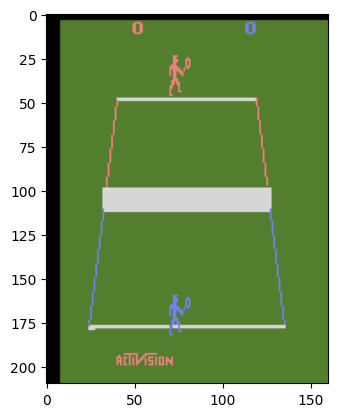

In [8]:
# Define a dictionary to hold hyperparameters for the DQN training process
hyper_params = {
    "env": "TennisDeterministic-v4",  # The environment to be used (a specific variant of the Tennis game)
    "replay-buffer-size": int(5e3),  # Maximum size of the replay buffer (5000 experiences)
    "learning-rate": 1e-4,  # Learning rate for the optimizer
    "discount-factor": 0.95,  # Discount factor (gamma) for future rewards
    "num-steps": int(1e6),  # Total number of steps to run the training for (1,000,000 steps)
    "batch-size": 32,  # Size of the mini-batch sampled from the replay buffer
    "learning-starts": 10000,  # Number of steps before learning starts (to populate replay buffer)
    "learning-freq": 1,  # Frequency of learning updates (every 1 step)
    "target-update-freq": 100,  # Frequency of updating the target network (every 100 steps)
    "eps-start": 1,  # Starting value of epsilon for epsilon-greedy exploration
    "eps-end": 0.05,  # Minimum value of epsilon for epsilon-greedy exploration
    "eps-decay": 0.995,  # Rate at which epsilon decays after each episode
    "print-freq": 10  # Frequency of printing updates during training (every 10 episodes)
}

# Create the environment using the specified environment name from hyperparameters
env = gym.make(hyper_params["env"], render_mode='rgb_array')
env.reset()  # Reset the environment to its initial state
plt.imshow(env.render())  # Render the environment and display the initial state


In [9]:
# Apply a series of environment wrappers to preprocess observations and actions
env = NoopResetEnv(env, noop_max=30)  # Apply random no-ops at the start of an episode for added randomness
env = MaxAndSkipEnv(env, skip=4)  # Skip frames and return the max frame over the skipped frames for efficiency
env = EpisodicLifeEnv(env)  # Make episodes end when a life is lost, but not the entire game
env = FireResetEnv(env)  # Automatically perform the FIRE action at the start of episodes where required
env = WarpFrame(env)  # Convert frames to grayscale and resize them to 84x80 for input to the network
env = PyTorchFrame(env)  # Reorder frame dimensions to be channel-first for compatibility with PyTorch
env = ClipRewardEnv(env)  # Clip rewards to be in the range [-1, 0, 1] for stability
env = FrameStack(env, 4)  # Stack the last 4 frames together to provide temporal context to the agent

# Create a replay buffer with the specified size from hyperparameters
replay_buffer = ReplayBuffer(hyper_params["replay-buffer-size"])

# Initialize the Dueling DQN agent with the environment's observation and action spaces,
# the replay buffer, learning rate, batch size, and discount factor from the hyperparameters
agent = DuelingDQNAgent(
    env.observation_space,  # Observation space of the environment
    env.action_space,  # Action space of the environment
    replay_buffer,  # Replay buffer for storing experiences
    lr=hyper_params['learning-rate'],  # Learning rate for the optimizer
    batch_size=hyper_params['batch-size'],  # Batch size for training
    gamma=hyper_params['discount-factor'],  # Discount factor for future rewards
)


Using device cuda


# Main Training Loop

In [10]:
# Initialize the epsilon threshold for epsilon-greedy exploration
eps_threshold = hyper_params["eps-start"]

# List to store rewards for each episode
episode_rewards = [0.0]

# List to store cumulative rewards for logging
cumulative_rewards = []

# Reset the environment and get the initial state
state, _ = env.reset(seed=seed)

# Main training loop running for the specified number of steps
for t in range(hyper_params["num-steps"]):
        
    # Update epsilon for exploration-exploitation trade-off
    if eps_threshold > hyper_params["eps-end"]:
        eps_threshold *= hyper_params["eps-decay"]
    else:
        eps_threshold = hyper_params["eps-end"]
    
    # Decide whether to explore or exploit based on epsilon-greedy strategy
    sample = random.random()
    if sample > eps_threshold:
        action = agent.act(state)  # Exploit: choose the best action according to the policy
    else:
        action = env.action_space.sample()  # Explore: choose a random action

    # Take the action and observe the next state, reward, and done flag
    next_state, reward, done, info, _ = env.step(action)
    
    # Add the experience to the replay buffer
    agent.memory.add(state, action, reward, next_state, float(done))
    
    # Update the current state
    state = next_state

    # Accumulate the reward for the current episode
    episode_rewards[-1] += reward
    
    # If the episode is done, reset the environment and start a new episode
    if done:
        state, _ = env.reset(seed=seed)
        episode_rewards.append(0.0)

    # Start training after a certain number of steps and update the policy network
    if t > hyper_params["learning-starts"] and t % hyper_params["learning-freq"] == 0:
        loss = agent.optimise_td_loss()
        writer.add_scalar('Loss', loss, t)  # Log loss to TensorBoard

    # Periodically update the target network to match the policy network
    if t > hyper_params["learning-starts"] and t % hyper_params["target-update-freq"] == 0:
        agent.update_target_network()

    # Track the number of completed episodes
    num_episodes = len(episode_rewards)

    # If the episode is done, calculate and log cumulative rewards
    if done:
        cumulative_reward = sum(episode_rewards[-5:]) / 5  # Average reward over the last 5 episodes
        cumulative_rewards.append(cumulative_reward)

        # Log various metrics to TensorBoard
        writer.add_scalar('Score per Step', episode_rewards[-2], t)  # Log score at each step
        writer.add_scalar('Score per Episode', episode_rewards[-2], num_episodes)  # Log score per episode
        writer.add_scalar('Average Cumulative Reward (Last 5 Episodes)', cumulative_reward, num_episodes)  # Log avg cumulative reward

        # Print progress every few episodes
        if hyper_params["print-freq"] is not None and len(episode_rewards) % hyper_params["print-freq"] == 0:
            mean_100ep_reward = round(np.mean(episode_rewards[-101:-1]), 1)
            print("********************************************************")
            print("steps: {}".format(t))
            print("episodes: {}".format(num_episodes))
            print("mean 100 episode reward: {}".format(mean_100ep_reward))
            print("% time spent exploring: {}".format(int(100 * eps_threshold)))
            print("********************************************************")
            
            # Save a checkpoint of the policy network and rewards
            torch.save(agent.policy_network.state_dict(), f'checkpoint.pth')
            np.savetxt('rewards_per_episode.csv', episode_rewards, delimiter=',', fmt='%1.3f')
            np.savetxt('cumulative_rewards.csv', cumulative_rewards, delimiter=',', fmt='%1.3f')
        
        # Periodically save the model after a certain number of episodes
        if num_episodes > 300 and num_episodes % 50 == 0:
            agent.save(f'dueling_model_{dff}/checkpoint_{num_episodes}.pth')

********************************************************
steps: 8865
episodes: 10
mean 100 episode reward: -23.9
% time spent exploring: 5
********************************************************
********************************************************
steps: 17889
episodes: 20
mean 100 episode reward: -23.9
% time spent exploring: 5
********************************************************
********************************************************
steps: 33422
episodes: 30
mean 100 episode reward: -23.7
% time spent exploring: 5
********************************************************
********************************************************
steps: 46287
episodes: 40
mean 100 episode reward: -23.6
% time spent exploring: 5
********************************************************
********************************************************
steps: 58254
episodes: 50
mean 100 episode reward: -23.5
% time spent exploring: 5
********************************************************
****************

KeyboardInterrupt: 

In [11]:
agent.save(f'dueling_model_{dff}/final_model.pth')

Model saved to dueling_model_20240804-012452/final_model.pth


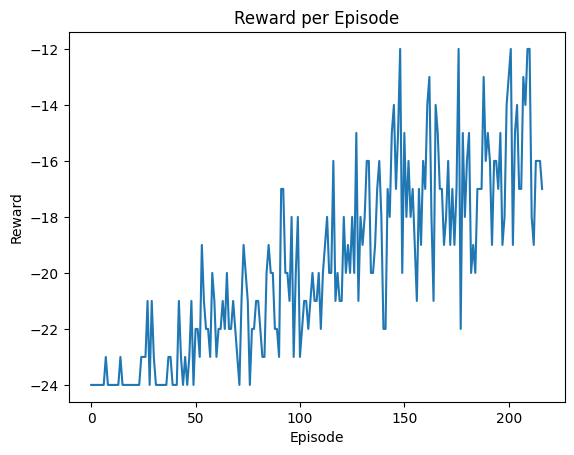

In [12]:
# plot rewards
import matplotlib.pyplot as plt
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward per Episode')
plt.show()
